In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(r"E:\Data Science _Assignment_Intern\DataScience_challenge\dataset\aircraft_engine_sensor_data.csv")
params = pd.read_csv(r"E:\Data Science _Assignment_Intern\DataScience_challenge\dataset\parameter_dictionary.csv")

In [5]:
print("\n[2] INITIAL DATA EXPLORATION")
print("-"*80)

# Basic info
print(f"\nDate range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Number of unique aircraft: {df['aircraft no'].nunique()}")
print(f"Number of unique engines: {df['engine no'].nunique()}")
print(f"Total observations: {len(df)}")

# Check data distribution per engine
engine_counts = df.groupby('engine no').size()
print(f"\nObservations per engine - Mean: {engine_counts.mean():.0f}, Std: {engine_counts.std():.0f}")
print(f"Min: {engine_counts.min()}, Max: {engine_counts.max()}")


[2] INITIAL DATA EXPLORATION
--------------------------------------------------------------------------------

Date range: 01/01/2020 00:12 to 31/12/2019 22:52
Number of unique aircraft: 25
Number of unique engines: 40
Total observations: 76911

Observations per engine - Mean: 1923, Std: 909
Min: 618, Max: 3689


In [6]:
# ============================================================================
# 3. MISSING VALUES ANALYSIS
# ============================================================================
print("\n[3] MISSING VALUES ANALYSIS")
print("-"*80)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print("\nColumns with missing values:")
print(missing_df[missing_df['Missing Count'] > 0])

# Identify critical vs non-critical columns
critical_cols = ['TGT', 'FF', 'N1', 'N2', 'N3', 'T3', 'T25', 'P3', 'EPR']
print(f"\nMissing values in CRITICAL columns for TGT analysis:")
for col in critical_cols:
    if col in df.columns:
        miss_pct = (df[col].isnull().sum() / len(df)) * 100
        print(f"  {col}: {miss_pct:.2f}%")



[3] MISSING VALUES ANALYSIS
--------------------------------------------------------------------------------

Columns with missing values:
             Missing Count  Percentage
AP1                  76911  100.000000
AP2                  76911  100.000000
Unnamed: 27          76911  100.000000
GWT                  62225   80.905202
FF                      10    0.013002
EPR                      6    0.007801
N1                       4    0.005201
P3                       2    0.002600
P160                     1    0.001300
TN                       1    0.001300
T25                      1    0.001300

Missing values in CRITICAL columns for TGT analysis:
  TGT: 0.00%
  FF: 0.01%
  N1: 0.01%
  N2: 0.00%
  N3: 0.00%
  T3: 0.00%
  T25: 0.00%
  P3: 0.00%
  EPR: 0.01%


In [7]:
# Missing Values Handling Strategy
# Handling missing data before modeling

print("="*80)
print("MISSING VALUES HANDLING")
print("="*80)

print("\n[STEP 1] DROP USELESS COLUMNS")
print("-"*80)

# Columns to drop (100% missing or not needed)
cols_to_drop = ['AP1', 'AP2', 'Unnamed: 27', 'GWT']
print(f"Dropping columns: {cols_to_drop}")

df_clean = df.drop(columns=cols_to_drop, errors='ignore')
print(f"✓ Shape after dropping: {df_clean.shape}")

print("\n[STEP 2] ANALYZE REMAINING MISSING VALUES")
print("-"*80)

missing_after = df_clean.isnull().sum()
missing_after = missing_after[missing_after > 0].sort_values(ascending=False)
print("\nRemaining missing values:")
print(missing_after)
print(f"\nTotal rows: {len(df_clean)}")

print("\n[STEP 3] IMPUTATION STRATEGY")
print("-"*80)

# Strategy for each column with missing values
print("""
Strategy per column:
- FF (Fuel Flow): 10 missing (0.01%) → Forward fill by engine, then drop if still missing
- EPR (Engine Pressure Ratio): 6 missing (0.01%) → Forward fill by engine, then drop
- N1 (Low Pressure Shaft Speed): 4 missing (0.01%) → Forward fill by engine, then drop
- P3 (High Pressure Compressor Delivery Pressure): 2 missing → Forward fill by engine
- P160, TN, T25: 1 missing each → Forward fill by engine, then drop if needed

Rationale:
- These are sensor readings that should be continuous within an engine's operation
- Forward fill within same engine preserves temporal continuity
- With <0.02% missing, dropping remaining NaNs won't significantly impact data
""")

print("\n[STEP 4] APPLY IMPUTATION")
print("-"*80)

# Convert datetime to proper format for sorting
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

# Sort by engine and time
df_clean = df_clean.sort_values(['engine no', 'datetime'])

# Columns with missing values (excluding already dropped ones)
cols_with_missing = missing_after.index.tolist()

print(f"\nApplying forward fill by engine for columns: {cols_with_missing}")

# Forward fill within each engine group
for col in cols_with_missing:
    if col in df_clean.columns:
        # Forward fill within engine groups
        df_clean[col] = df_clean.groupby('engine no')[col].fillna(method='ffill')

        # Backward fill for any remaining (start of sequence)
        df_clean[col] = df_clean.groupby('engine no')[col].fillna(method='bfill')

print("✓ Forward/backward fill completed")

# Check remaining missing values
remaining_missing = df_clean[cols_with_missing].isnull().sum()
print(f"\nRemaining missing values after imputation:")
print(remaining_missing[remaining_missing > 0])

print("\n[STEP 5] FINAL CLEANUP")
print("-"*80)

# Drop any remaining rows with missing critical values
critical_cols = ['TGT', 'FF', 'N1', 'N2', 'N3', 'T3', 'EPR']
rows_before = len(df_clean)

# Drop rows where ANY critical column is missing
df_clean = df_clean.dropna(subset=[col for col in critical_cols if col in df_clean.columns])

rows_after = len(df_clean)
rows_dropped = rows_before - rows_after

print(f"Rows before: {rows_before}")
print(f"Rows after: {rows_after}")
print(f"Rows dropped: {rows_dropped} ({(rows_dropped/rows_before)*100:.3f}%)")

print("\n[STEP 6] VALIDATION")
print("-"*80)

# Final missing values check
final_missing = df_clean.isnull().sum()
final_missing = final_missing[final_missing > 0]

if len(final_missing) == 0:
    print("✓ SUCCESS: No missing values in cleaned dataset!")
else:
    print("⚠ Warning: Some missing values remain:")
    print(final_missing)

print(f"\nFinal dataset shape: {df_clean.shape}")
print(f"Engines in final dataset: {df_clean['engine no'].nunique()}")



MISSING VALUES HANDLING

[STEP 1] DROP USELESS COLUMNS
--------------------------------------------------------------------------------
Dropping columns: ['AP1', 'AP2', 'Unnamed: 27', 'GWT']
✓ Shape after dropping: (76911, 24)

[STEP 2] ANALYZE REMAINING MISSING VALUES
--------------------------------------------------------------------------------

Remaining missing values:
FF      10
EPR      6
N1       4
P3       2
P160     1
TN       1
T25      1
dtype: int64

Total rows: 76911

[STEP 3] IMPUTATION STRATEGY
--------------------------------------------------------------------------------

Strategy per column:
- FF (Fuel Flow): 10 missing (0.01%) → Forward fill by engine, then drop if still missing
- EPR (Engine Pressure Ratio): 6 missing (0.01%) → Forward fill by engine, then drop
- N1 (Low Pressure Shaft Speed): 4 missing (0.01%) → Forward fill by engine, then drop
- P3 (High Pressure Compressor Delivery Pressure): 2 missing → Forward fill by engine
- P160, TN, T25: 1 missing each 

In [8]:
print("\n[STEP 7] SAVE CLEANED DATA")
print("-"*80)

# Save cleaned data for modeling
df_clean.to_csv('aircraft_engine_sensor_data_cleaned.csv', index=False)
print("✓ Saved: aircraft_engine_sensor_data_cleaned.csv")

print("\n" + "="*80)
print("MISSING VALUES HANDLING COMPLETE")
print("="*80)
print("""
Summary:
✓ Dropped 4 useless columns (100% missing or not needed)
✓ Imputed <0.02% missing values using forward/backward fill by engine
✓ Dropped minimal rows with remaining critical missing values
✓ Clean dataset ready for modeling

Next: Proceed with TGT analysis and feature engineering
""")

# Return cleaned dataframe for next steps
# df_clean is now ready to use


[STEP 7] SAVE CLEANED DATA
--------------------------------------------------------------------------------
✓ Saved: aircraft_engine_sensor_data_cleaned.csv

MISSING VALUES HANDLING COMPLETE

Summary:
✓ Dropped 4 useless columns (100% missing or not needed)
✓ Imputed <0.02% missing values using forward/backward fill by engine
✓ Dropped minimal rows with remaining critical missing values
✓ Clean dataset ready for modeling

Next: Proceed with TGT analysis and feature engineering



In [9]:
import os
print(os.getcwd())


e:\Data Science _Assignment_Intern\DataScience_challenge\notebooks


In [10]:
import sqlite3
import os

print("Writing DB in:", os.getcwd())

conn = sqlite3.connect("engine_data.db")

df_clean.to_sql(
    "engine_sensor_data",
    conn,
    if_exists="replace",
    index=False
)

conn.close()

print("✅ engine_data.db created with table engine_sensor_data")


Writing DB in: e:\Data Science _Assignment_Intern\DataScience_challenge\notebooks
✅ engine_data.db created with table engine_sensor_data


In [11]:
# ============================================================================
# 4. TGT DISTRIBUTION ANALYSIS (KEY PARAMETER)
# ============================================================================
print("\n[4] TGT (TURBINE GAS TEMPERATURE) ANALYSIS")
print("-"*80)

print(f"\nOverall TGT statistics:")
print(df['TGT'].describe())

# TGT by engine
tgt_by_engine = df.groupby('engine no')['TGT'].agg(['mean', 'std', 'min', 'max', 'count'])
print(f"\nTGT statistics by engine:")
print(tgt_by_engine.describe())

# Check for potential anomalies (engines with unusually high mean TGT)
high_tgt_threshold = tgt_by_engine['mean'].quantile(0.90)
print(f"\n90th percentile TGT: {high_tgt_threshold:.2f}")
potential_anomalies = tgt_by_engine[tgt_by_engine['mean'] > high_tgt_threshold]
print(f"Engines with mean TGT > 90th percentile: {len(potential_anomalies)}")


[4] TGT (TURBINE GAS TEMPERATURE) ANALYSIS
--------------------------------------------------------------------------------

Overall TGT statistics:
count    76911.000000
mean       613.436713
std         29.919178
min        389.000000
25%        594.000000
50%        616.000000
75%        635.000000
max        740.000000
Name: TGT, dtype: float64

TGT statistics by engine:
             mean        std         min        max        count
count   40.000000  40.000000   40.000000   40.00000    40.000000
mean   615.253168  24.207236  512.075000  696.52500  1922.775000
std     15.668495   4.871738   41.227566   20.30282   909.039575
min    588.074391  14.965284  389.000000  649.00000   618.000000
25%    603.584869  20.451402  498.000000  683.50000  1016.000000
50%    613.653003  24.793800  508.500000  694.50000  1719.000000
75%    628.399425  28.193152  548.250000  709.75000  2717.500000
max    645.172075  31.713808  579.000000  740.00000  3689.000000

90th percentile TGT: 635.49
Engines


[5] GENERATING VISUALIZATIONS...
✓ Saved: tgt_analysis.png


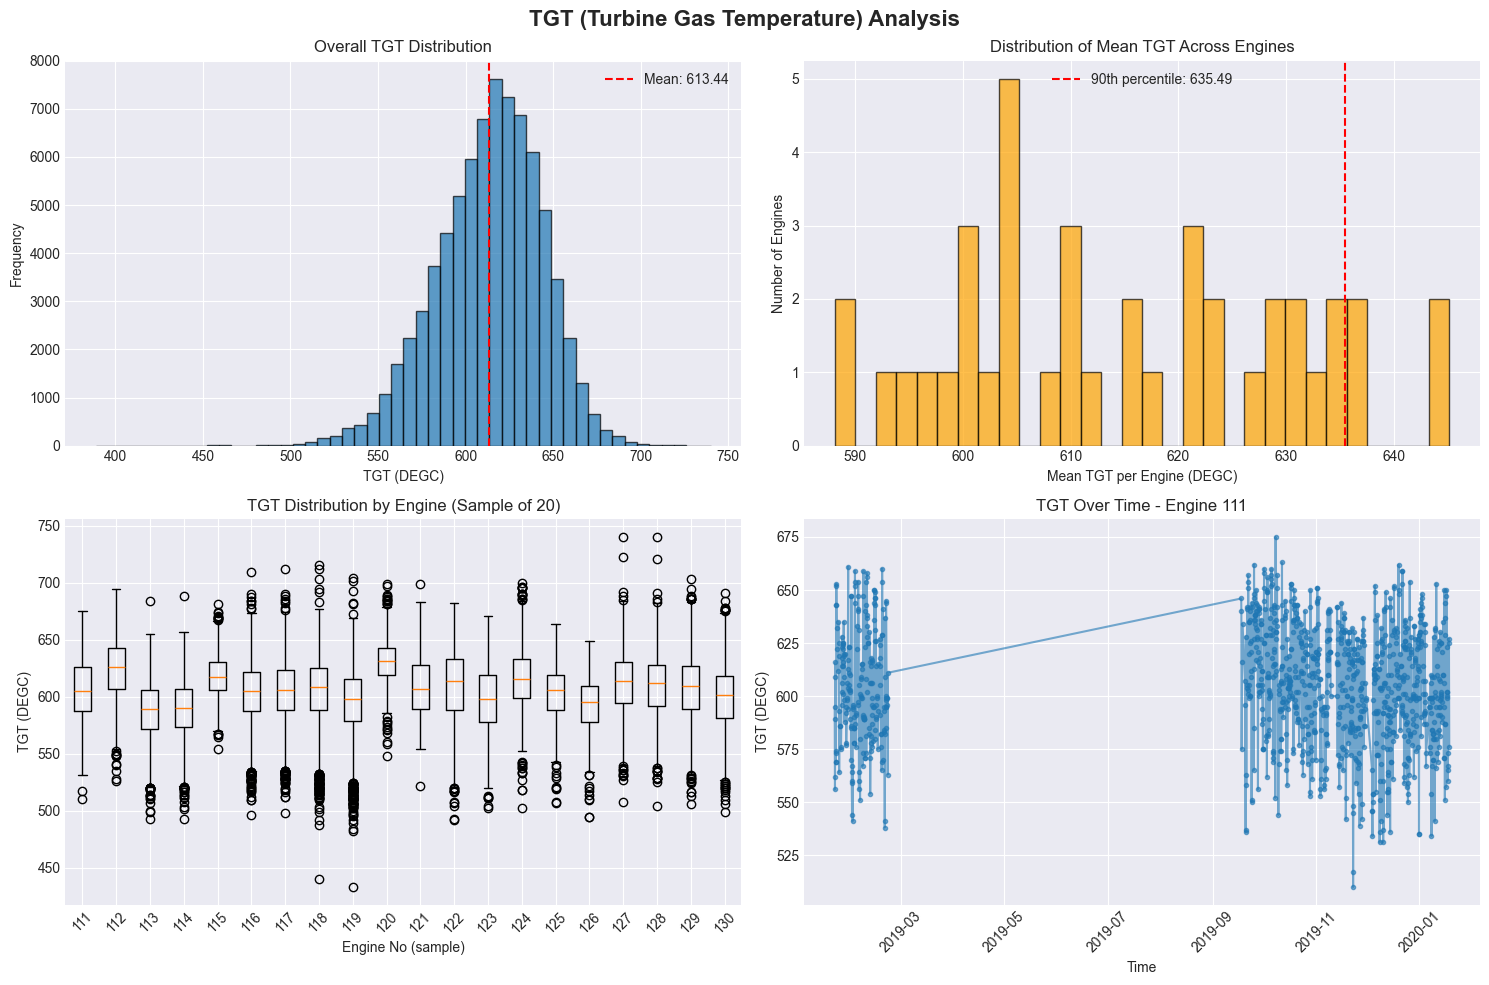

In [12]:
# ============================================================================
# 5. VISUALIZATION - TGT DISTRIBUTION
# ============================================================================
print("\n[5] GENERATING VISUALIZATIONS...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('TGT (Turbine Gas Temperature) Analysis', fontsize=16, fontweight='bold')

# Overall TGT distribution
axes[0, 0].hist(df['TGT'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('TGT (DEGC)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Overall TGT Distribution')
axes[0, 0].axvline(df['TGT'].mean(), color='red', linestyle='--', label=f'Mean: {df["TGT"].mean():.2f}')
axes[0, 0].legend()

# TGT by engine (mean)
axes[0, 1].hist(tgt_by_engine['mean'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Mean TGT per Engine (DEGC)')
axes[0, 1].set_ylabel('Number of Engines')
axes[0, 1].set_title('Distribution of Mean TGT Across Engines')
axes[0, 1].axvline(high_tgt_threshold, color='red', linestyle='--', label=f'90th percentile: {high_tgt_threshold:.2f}')
axes[0, 1].legend()

# Box plot of TGT by engine (sample)
sample_engines = df['engine no'].unique()[:20]  # Sample first 20 engines
df_sample = df[df['engine no'].isin(sample_engines)]
axes[1, 0].boxplot([df_sample[df_sample['engine no'] == eng]['TGT'].dropna()
                     for eng in sample_engines], labels=sample_engines)
axes[1, 0].set_xlabel('Engine No (sample)')
axes[1, 0].set_ylabel('TGT (DEGC)')
axes[1, 0].set_title('TGT Distribution by Engine (Sample of 20)')
axes[1, 0].tick_params(axis='x', rotation=45)

# TGT over time (sample engine)
sample_engine = df['engine no'].iloc[0]
df_time = df[df['engine no'] == sample_engine].copy()
df_time['datetime'] = pd.to_datetime(df_time['datetime'])
df_time = df_time.sort_values('datetime')
axes[1, 1].plot(df_time['datetime'], df_time['TGT'], marker='o', markersize=3, alpha=0.6)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('TGT (DEGC)')
axes[1, 1].set_title(f'TGT Over Time - Engine {sample_engine}')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('tgt_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: tgt_analysis.png")



[6] CORRELATION ANALYSIS
--------------------------------------------------------------------------------

Correlation with TGT:
TGT    1.000000
N3     0.970739
N2     0.924061
T3     0.905139
N1     0.896208
T25    0.761405
EPR    0.651427
FF     0.496957
MN     0.467598
T2     0.260626
P3     0.103353
P50   -0.129514
Name: TGT, dtype: float64

✓ Saved: correlation_matrix.png


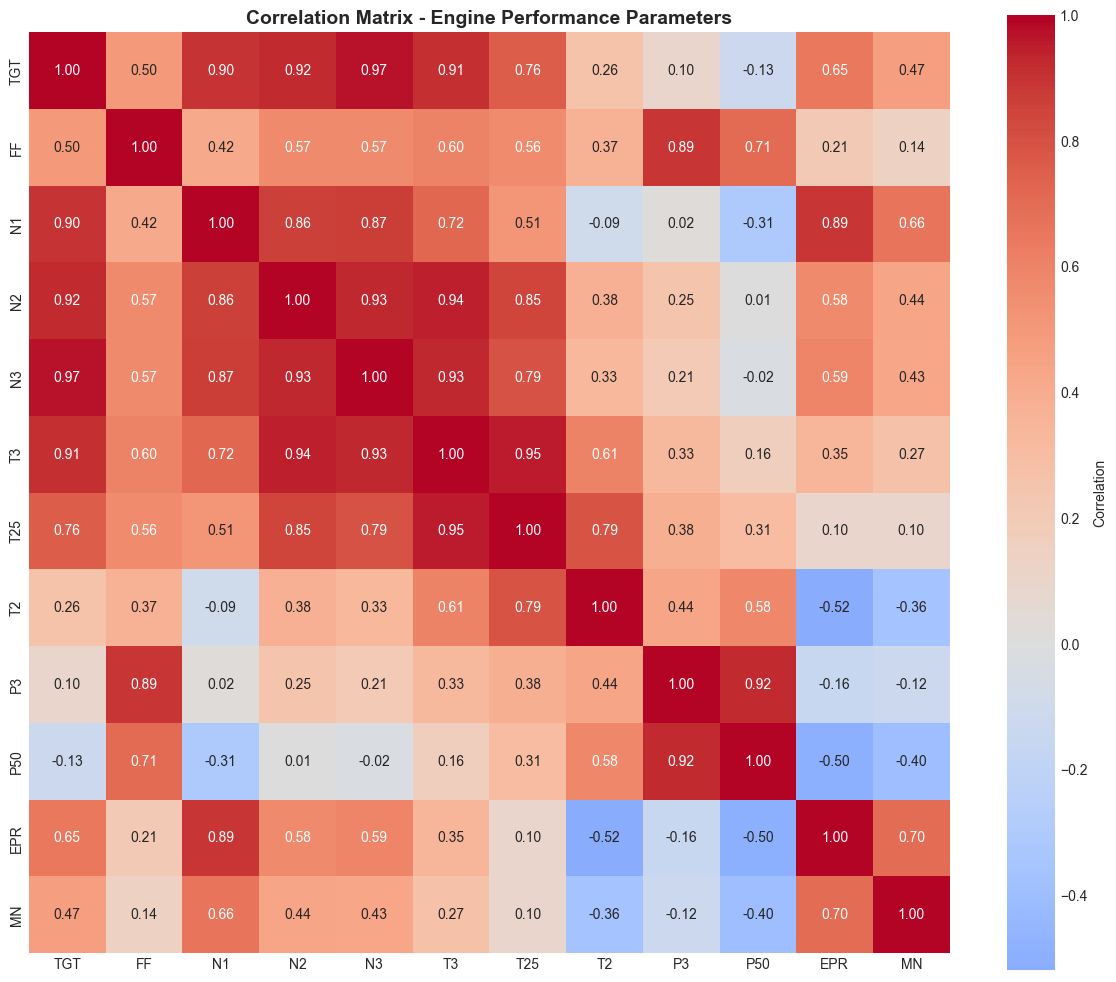

In [13]:
#============================================================================
# 6. CORRELATION ANALYSIS
# ============================================================================
print("\n[6] CORRELATION ANALYSIS")
print("-"*80)

# Select numerical columns related to engine performance
perf_cols = ['TGT', 'FF', 'N1', 'N2', 'N3', 'T3', 'T25', 'T2', 'P3', 'P50', 'EPR', 'MN']
perf_cols = [col for col in perf_cols if col in df.columns]

correlation_matrix = df[perf_cols].corr()
print("\nCorrelation with TGT:")
tgt_corr = correlation_matrix['TGT'].sort_values(ascending=False)
print(tgt_corr)

# Visualization
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix - Engine Performance Parameters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: correlation_matrix.png")

In [14]:
# ============================================================================
# 7. KEY INSIGHTS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("KEY INSIGHTS FROM EDA")
print("="*80)

print(f"""
1. Dataset Overview:
   - Total engines analyzed: {df['engine no'].nunique()}
   - Total observations: {len(df)}
   - Average readings per engine: {engine_counts.mean():.0f}

2. TGT Analysis:
   - Mean TGT: {df['TGT'].mean():.2f} DEGC
   - Std TGT: {df['TGT'].std():.2f} DEGC
   - Potential anomalous engines (>90th percentile): {len(potential_anomalies)}

3. Data Quality:
   - Critical columns with minimal missing data: {[col for col in critical_cols if col in df.columns and df[col].isnull().sum() < 100]}
   - High missing columns to drop: GWT, AP1, AP2, Unnamed: 27

4. Strong TGT Correlations:
   {tgt_corr.head(5).to_string()}

Next Steps:
→ Feature engineering based on correlations
→ Build anomaly detection model
→ Identify affected engines
""")

print("\n✓ EDA Complete! Ready for modeling phase.")
print("="*80)


KEY INSIGHTS FROM EDA

1. Dataset Overview:
   - Total engines analyzed: 40
   - Total observations: 76911
   - Average readings per engine: 1923

2. TGT Analysis:
   - Mean TGT: 613.44 DEGC
   - Std TGT: 29.92 DEGC
   - Potential anomalous engines (>90th percentile): 4

3. Data Quality:
   - Critical columns with minimal missing data: ['TGT', 'FF', 'N1', 'N2', 'N3', 'T3', 'EPR']
   - High missing columns to drop: GWT, AP1, AP2, Unnamed: 27

4. Strong TGT Correlations:
   TGT    1.000000
N3     0.970739
N2     0.924061
T3     0.905139
N1     0.896208

Next Steps:
→ Feature engineering based on correlations
→ Build anomaly detection model
→ Identify affected engines


✓ EDA Complete! Ready for modeling phase.


In [15]:
# ============================================================================
# STEP 1: FEATURE ENGINEERING
# ============================================================================
print("\n[STEP 1] FEATURE ENGINEERING")
print("-"*80)

# Create engine-level aggregated features
# These capture the "normal behavior" of each engine

engine_features = df_clean.groupby('engine no').agg({
    # TGT statistics (our main target)
    'TGT': ['mean', 'std', 'max', 'min', lambda x: x.quantile(0.95), lambda x: x.quantile(0.05)],

    # Fuel flow
    'FF': ['mean', 'std', 'max'],

    # Shaft speeds
    'N1': ['mean', 'std'],
    'N2': ['mean', 'std'],
    'N3': ['mean', 'std'],

    # Temperatures
    'T2': ['mean', 'std'],
    'T3': ['mean', 'std'],
    'T25': ['mean', 'std'],

    # Pressures
    'P3': ['mean', 'std'],
    'P50': ['mean', 'std'],
    'EPR': ['mean', 'std'],

    # Operating conditions
    'MN': ['mean'],  # Mach number

    # Count of observations
    'datetime': 'count'
}).reset_index()

# Flatten column names
engine_features.columns = ['_'.join(col).strip('_') if col[1] else col[0]
                           for col in engine_features.columns.values]

# Rename lambda columns
engine_features.columns = engine_features.columns.str.replace('<lambda_0>', 'p95')
engine_features.columns = engine_features.columns.str.replace('<lambda_1>', 'p05')
engine_features.columns = engine_features.columns.str.replace('datetime_count', 'observation_count')

print(f"✓ Created {len(engine_features.columns)-1} features for {len(engine_features)} engines")
print(f"\nFeature columns: {list(engine_features.columns[1:])}")


[STEP 1] FEATURE ENGINEERING
--------------------------------------------------------------------------------
✓ Created 29 features for 40 engines

Feature columns: ['TGT_mean', 'TGT_std', 'TGT_max', 'TGT_min', 'TGT_p95', 'TGT_p05', 'FF_mean', 'FF_std', 'FF_max', 'N1_mean', 'N1_std', 'N2_mean', 'N2_std', 'N3_mean', 'N3_std', 'T2_mean', 'T2_std', 'T3_mean', 'T3_std', 'T25_mean', 'T25_std', 'P3_mean', 'P3_std', 'P50_mean', 'P50_std', 'EPR_mean', 'EPR_std', 'MN_mean', 'observation_count']


In [ ]:
# ============================================================================
# STEP 2: CREATE DERIVED FEATURES
# ============================================================================


# Add some domain-specific derived features
# TGT relative to operating conditions
engine_features['TGT_per_FF'] = engine_features['TGT_mean'] / engine_features['FF_mean']
engine_features['TGT_per_N1'] = engine_features['TGT_mean'] / engine_features['N1_mean']
engine_features['TGT_per_N2'] = engine_features['TGT_mean'] / engine_features['N2_mean']

# TGT variability
engine_features['TGT_range'] = engine_features['TGT_max'] - engine_features['TGT_min']
engine_features['TGT_cv'] = engine_features['TGT_std'] / engine_features['TGT_mean']  # Coefficient of variation

# Efficiency indicators
engine_features['FF_per_N1'] = engine_features['FF_mean'] / engine_features['N1_mean']
engine_features['T3_to_T2_ratio'] = engine_features['T3_mean'] / engine_features['T2_mean']

print(f"✓ Added 7 derived features")
print(f"Total features now: {len(engine_features.columns)-1}")



[STEP 2] CREATE DERIVED FEATURES
--------------------------------------------------------------------------------
✓ Added 7 derived features
Total features now: 36


In [17]:
# ============================================================================
# STEP 3: FEATURE SELECTION & SCALING
# ============================================================================
print("\n[STEP 3] FEATURE SELECTION & SCALING")
print("-"*80)


# Select features for modeling (exclude engine no)
feature_cols = [col for col in engine_features.columns if col != 'engine no']
X = engine_features[feature_cols].copy()

print(f"Features for modeling: {len(feature_cols)}")
print(f"Samples: {len(X)}")

# Check for any inf or nan values
X = X.replace([np.inf, -np.inf], np.nan)
print(f"\nNaN values after inf replacement: {X.isnull().sum().sum()}")

# Fill any NaN with median (safety check)
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())
    print("✓ Filled NaN values with median")

# Standardize features (important for distance-based anomaly detection)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

print("✓ Features standardized (mean=0, std=1)")



[STEP 3] FEATURE SELECTION & SCALING
--------------------------------------------------------------------------------
Features for modeling: 36
Samples: 40

NaN values after inf replacement: 0
✓ Features standardized (mean=0, std=1)


In [18]:
#============================================================================
# STEP 4: DIMENSIONALITY REDUCTION (OPTIONAL - FOR VISUALIZATION)
# ============================================================================
print("\n[STEP 4] PCA FOR VISUALIZATION")
print("-"*80)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
print(f"PCA explained variance: PC1={explained_var[0]:.2%}, PC2={explained_var[1]:.2%}")
print(f"Total: {sum(explained_var):.2%}")



[STEP 4] PCA FOR VISUALIZATION
--------------------------------------------------------------------------------
PCA explained variance: PC1=52.79%, PC2=16.04%
Total: 68.84%


In [19]:
#============================================================================
# STEP 5: TRAIN ISOLATION FOREST MODEL
# ============================================================================
print("\n[STEP 5] TRAIN ISOLATION FOREST MODEL")
print("-"*80)

# Isolation Forest parameters
# contamination: expected proportion of anomalies (we'll set conservative)
# random_state: for reproducibility

iso_forest = IsolationForest(
    contamination=0.15,  # Expect ~15% anomalies (6 out of 40 engines)
    random_state=42,
    n_estimators=100,
    max_samples='auto',
    max_features=1.0
)

print("Training Isolation Forest...")
print(f"  - Contamination: 15%")
print(f"  - Estimators: 100")

# Fit the model
iso_forest.fit(X_scaled)

# Get predictions (-1 for anomaly, 1 for normal)
predictions = iso_forest.predict(X_scaled)
anomaly_scores = iso_forest.score_samples(X_scaled)  # Lower score = more anomalous

print("✓ Model trained successfully")


[STEP 5] TRAIN ISOLATION FOREST MODEL
--------------------------------------------------------------------------------
Training Isolation Forest...
  - Contamination: 15%
  - Estimators: 100
✓ Model trained successfully


In [20]:
# ============================================================================
# STEP 6: ANALYZE RESULTS
# ============================================================================
print("\n[STEP 6] ANOMALY DETECTION RESULTS")
print("-"*80)

# Add predictions to engine features
engine_features['anomaly'] = predictions
engine_features['anomaly_score'] = anomaly_scores
engine_features['is_anomalous'] = engine_features['anomaly'] == -1

# Count anomalies
n_anomalies = (predictions == -1).sum()
print(f"\n✓ Detected {n_anomalies} anomalous engines out of {len(engine_features)}")
print(f"  Anomaly rate: {n_anomalies/len(engine_features):.1%}")

# Get anomalous engines
anomalous_engines = engine_features[engine_features['is_anomalous']].copy()
anomalous_engines = anomalous_engines.sort_values('anomaly_score')  # Most anomalous first

print(f"\n{'='*80}")
print("ANOMALOUS ENGINES IDENTIFIED:")
print(f"{'='*80}")

for idx, row in anomalous_engines.iterrows():
    print(f"\nEngine {row['engine no']}:")
    print(f"  Mean TGT: {row['TGT_mean']:.2f}°C")
    print(f"  Max TGT: {row['TGT_max']:.2f}°C")
    print(f"  TGT Std: {row['TGT_std']:.2f}°C")
    print(f"  Mean Fuel Flow: {row['FF_mean']:.2f} LBHR")
    print(f"  Anomaly Score: {row['anomaly_score']:.4f} (lower = more anomalous)")



[STEP 6] ANOMALY DETECTION RESULTS
--------------------------------------------------------------------------------

✓ Detected 6 anomalous engines out of 40
  Anomaly rate: 15.0%

ANOMALOUS ENGINES IDENTIFIED:

Engine 115:
  Mean TGT: 617.84°C
  Max TGT: 681.00°C
  TGT Std: 18.32°C
  Mean Fuel Flow: 5519.59 LBHR
  Anomaly Score: -0.5742 (lower = more anomalous)

Engine 123:
  Mean TGT: 597.40°C
  Max TGT: 671.00°C
  TGT Std: 28.25°C
  Mean Fuel Flow: 5484.57 LBHR
  Anomaly Score: -0.5421 (lower = more anomalous)

Engine 148:
  Mean TGT: 636.86°C
  Max TGT: 726.00°C
  TGT Std: 22.77°C
  Mean Fuel Flow: 6258.05 LBHR
  Anomaly Score: -0.5390 (lower = more anomalous)

Engine 147:
  Mean TGT: 634.31°C
  Max TGT: 723.00°C
  TGT Std: 22.74°C
  Mean Fuel Flow: 6319.10 LBHR
  Anomaly Score: -0.5385 (lower = more anomalous)

Engine 126:
  Mean TGT: 592.43°C
  Max TGT: 649.00°C
  TGT Std: 22.99°C
  Mean Fuel Flow: 5790.43 LBHR
  Anomaly Score: -0.5356 (lower = more anomalous)

Engine 120:
  Mea


[STEP 7] GENERATING VISUALIZATIONS...
--------------------------------------------------------------------------------
✓ Saved: anomaly_detection_results.png


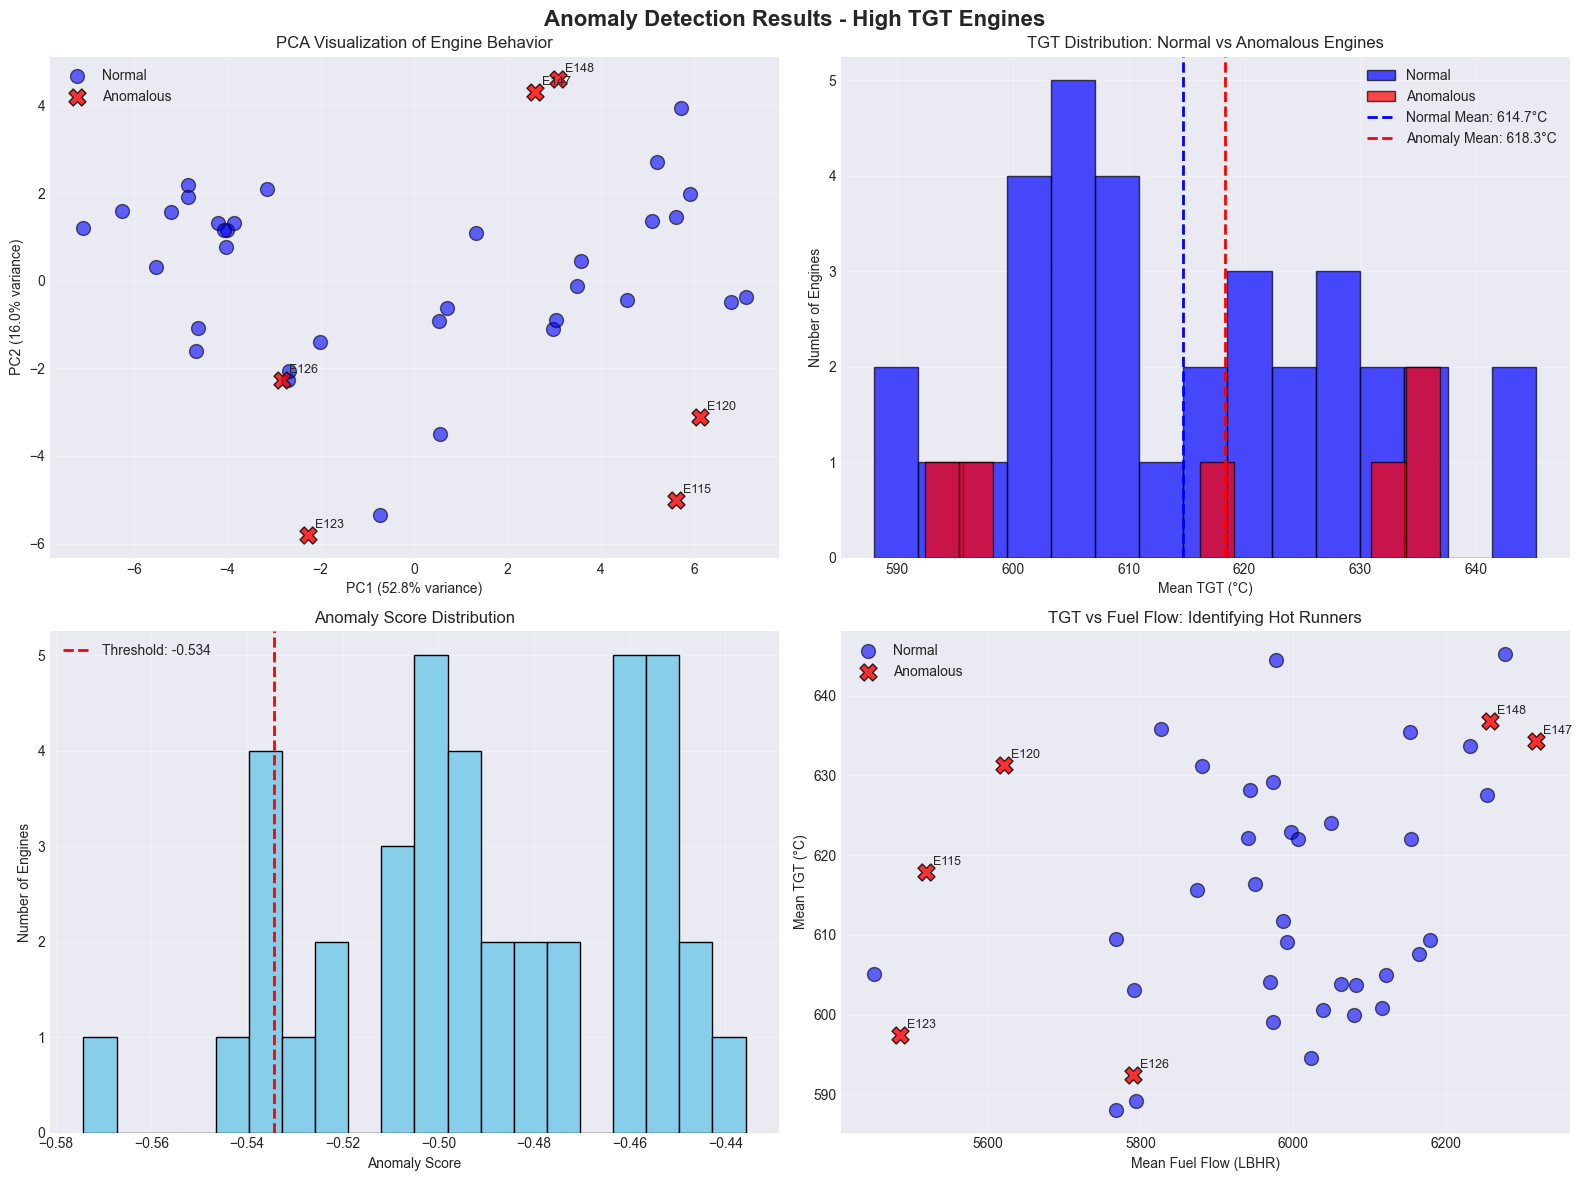

In [21]:

# ============================================================================
# STEP 7: VISUALIZATIONS
# ============================================================================
print("\n[STEP 7] GENERATING VISUALIZATIONS...")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Anomaly Detection Results - High TGT Engines', fontsize=16, fontweight='bold')

# 1. PCA visualization
ax1 = axes[0, 0]
normal_mask = engine_features['anomaly'] == 1
anomaly_mask = engine_features['anomaly'] == -1

ax1.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1],
           c='blue', label='Normal', alpha=0.6, s=100, edgecolors='black')
ax1.scatter(X_pca[anomaly_mask, 0], X_pca[anomaly_mask, 1],
           c='red', label='Anomalous', alpha=0.8, s=150, marker='X', edgecolors='black')

# Label anomalous engines
for idx in anomalous_engines.index:
    ax1.annotate(f"E{engine_features.loc[idx, 'engine no']}",
                (X_pca[idx, 0], X_pca[idx, 1]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax1.set_xlabel(f'PC1 ({explained_var[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({explained_var[1]:.1%} variance)')
ax1.set_title('PCA Visualization of Engine Behavior')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. TGT distribution comparison
ax2 = axes[0, 1]
normal_tgt = engine_features[engine_features['anomaly'] == 1]['TGT_mean']
anomaly_tgt = engine_features[engine_features['anomaly'] == -1]['TGT_mean']

ax2.hist(normal_tgt, bins=15, alpha=0.7, label='Normal', color='blue', edgecolor='black')
ax2.hist(anomaly_tgt, bins=15, alpha=0.7, label='Anomalous', color='red', edgecolor='black')
ax2.axvline(normal_tgt.mean(), color='blue', linestyle='--', linewidth=2, label=f'Normal Mean: {normal_tgt.mean():.1f}°C')
ax2.axvline(anomaly_tgt.mean(), color='red', linestyle='--', linewidth=2, label=f'Anomaly Mean: {anomaly_tgt.mean():.1f}°C')
ax2.set_xlabel('Mean TGT (°C)')
ax2.set_ylabel('Number of Engines')
ax2.set_title('TGT Distribution: Normal vs Anomalous Engines')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Anomaly score distribution
ax3 = axes[1, 0]
ax3.hist(engine_features['anomaly_score'], bins=20, color='skyblue', edgecolor='black')
threshold = engine_features[engine_features['anomaly'] == -1]['anomaly_score'].max()
ax3.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.3f}')
ax3.set_xlabel('Anomaly Score')
ax3.set_ylabel('Number of Engines')
ax3.set_title('Anomaly Score Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Engine-level comparison (TGT vs FF)
ax4 = axes[1, 1]
ax4.scatter(engine_features[normal_mask]['FF_mean'],
           engine_features[normal_mask]['TGT_mean'],
           c='blue', label='Normal', alpha=0.6, s=100, edgecolors='black')
ax4.scatter(engine_features[anomaly_mask]['FF_mean'],
           engine_features[anomaly_mask]['TGT_mean'],
           c='red', label='Anomalous', alpha=0.8, s=150, marker='X', edgecolors='black')

# Label anomalous engines
for idx in anomalous_engines.index:
    ax4.annotate(f"E{engine_features.loc[idx, 'engine no']}",
                (engine_features.loc[idx, 'FF_mean'], engine_features.loc[idx, 'TGT_mean']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax4.set_xlabel('Mean Fuel Flow (LBHR)')
ax4.set_ylabel('Mean TGT (°C)')
ax4.set_title('TGT vs Fuel Flow: Identifying Hot Runners')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('anomaly_detection_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved: anomaly_detection_results.png")

In [22]:
# ============================================================================
# STEP 8: SAVE MODEL AND ARTIFACTS
# ============================================================================
print("\n[STEP 8] SAVING MODEL AND ARTIFACTS")
print("-"*80)

# Save the trained model
joblib.dump(iso_forest, 'isolation_forest_model.pkl')
print("✓ Saved: isolation_forest_model.pkl")

# Save the scaler
joblib.dump(scaler, 'feature_scaler.pkl')
print("✓ Saved: feature_scaler.pkl")

# Save feature columns for pipeline
joblib.dump(feature_cols, 'feature_columns.pkl')
print("✓ Saved: feature_columns.pkl")

# Save results
results_df = engine_features[['engine no', 'TGT_mean', 'TGT_max', 'TGT_std',
                               'FF_mean', 'anomaly_score', 'is_anomalous']].copy()
results_df = results_df.sort_values('anomaly_score')
results_df.to_csv('anomaly_detection_results.csv', index=False)
print("✓ Saved: anomaly_detection_results.csv")



[STEP 8] SAVING MODEL AND ARTIFACTS
--------------------------------------------------------------------------------
✓ Saved: isolation_forest_model.pkl
✓ Saved: feature_scaler.pkl
✓ Saved: feature_columns.pkl
✓ Saved: anomaly_detection_results.csv


In [23]:

# ============================================================================
# STEP 9: FINAL SUMMARY
# ============================================================================
print("MODEL TRAINING COMPLETE - SUMMARY")

print(f"""
Model Performance:
  - Total engines analyzed: {len(engine_features)}
  - Anomalous engines detected: {n_anomalies}
  - Anomaly rate: {n_anomalies/len(engine_features):.1%}

Anomalous Engine Statistics:
  - Mean TGT (Normal): {normal_tgt.mean():.2f}°C ± {normal_tgt.std():.2f}
  - Mean TGT (Anomalous): {anomaly_tgt.mean():.2f}°C ± {anomaly_tgt.std():.2f}
  - Difference: {anomaly_tgt.mean() - normal_tgt.mean():.2f}°C higher

Anomalous Engines List:
{', '.join([f"Engine {e}" for e in anomalous_engines['engine no'].values])}


""")


MODEL TRAINING COMPLETE - SUMMARY

Model Performance:
  - Total engines analyzed: 40
  - Anomalous engines detected: 6
  - Anomaly rate: 15.0%

Anomalous Engine Statistics:
  - Mean TGT (Normal): 614.71°C ± 15.21
  - Mean TGT (Anomalous): 618.35°C ± 19.37
  - Difference: 3.64°C higher

Anomalous Engines List:
Engine 115, Engine 123, Engine 148, Engine 147, Engine 126, Engine 120





## Model Validation with Alternative Anomaly Detectors

In [24]:
from sklearn.neighbors import LocalOutlierFactor

# Fit LOF
lof = LocalOutlierFactor(
    n_neighbors=10,
    contamination=0.15
)

lof_preds = lof.fit_predict(X_scaled)

# Add results for comparison
engine_features["LOF_anomaly"] = lof_preds == -1

# Compare with Isolation Forest
comparison = engine_features[
    ["engine no", "is_anomalous", "LOF_anomaly"]
].copy()

comparison["agreement"] = (
    comparison["is_anomalous"].astype(int) +
    comparison["LOF_anomaly"].astype(int)
)

comparison.sort_values("agreement", ascending=False)


,engine no,is_anomalous,LOF_anomaly,agreement
12,123,True,True,2
15,126,True,True,2
0,111,False,True,1
2,113,False,True,1
14,125,False,True,1
9,120,True,False,1
3,114,False,True,1
4,115,True,False,1
37,148,True,False,1
36,147,True,False,1
